## Importing libraries

In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
#from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts 
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
import tensorflow as ts 
from  tensorflow import keras

# Data loading and exploring

In [3]:
data_dir = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets"
colon = os.listdir(data_dir)

In [4]:
colon

['colon_aca', 'colon_n']

In [5]:
# Number of images for each disease
nums_train = {}
for col in colon:
    nums_train[col] = len(os.listdir(data_dir + '/' + col))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
colon_aca,5000
colon_n,5000


<AxesSubplot:title={'center':'data distribution '}, xlabel='Type of colon cancer', ylabel='Number of image'>

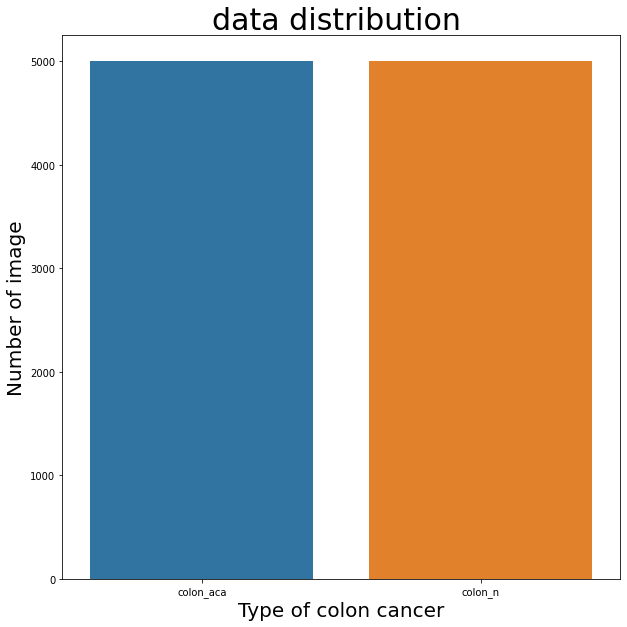

In [6]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of colon cancer',fontsize=20)

keys = list(nums_train.keys())
# get values in the same order as keys, and parse percentage values
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)


# Show some example for colon cancer

In [7]:
# Function to show image
train = ImageFolder(data_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

## Colon_aca

Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)
Label :colon_aca(0)


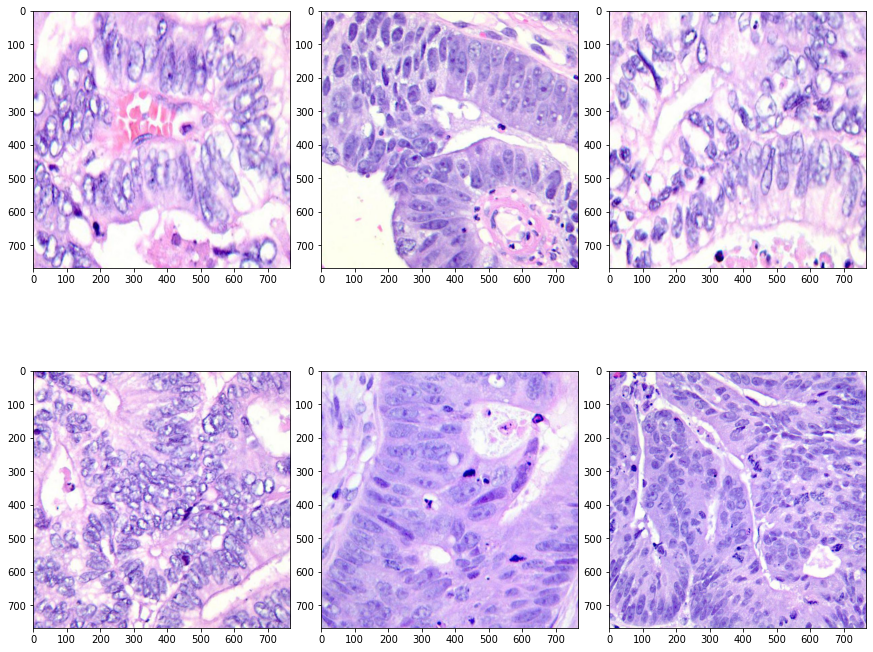

In [8]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[5]))
axs[1, 0].imshow(show_image(*train[6]))
axs[1,1].imshow(show_image(*train[10]))
axs[0,2].imshow(show_image(*train[20]))
axs[1,2].imshow(show_image(*train[30]))

## Colon_n

Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)
Label :colon_n(1)


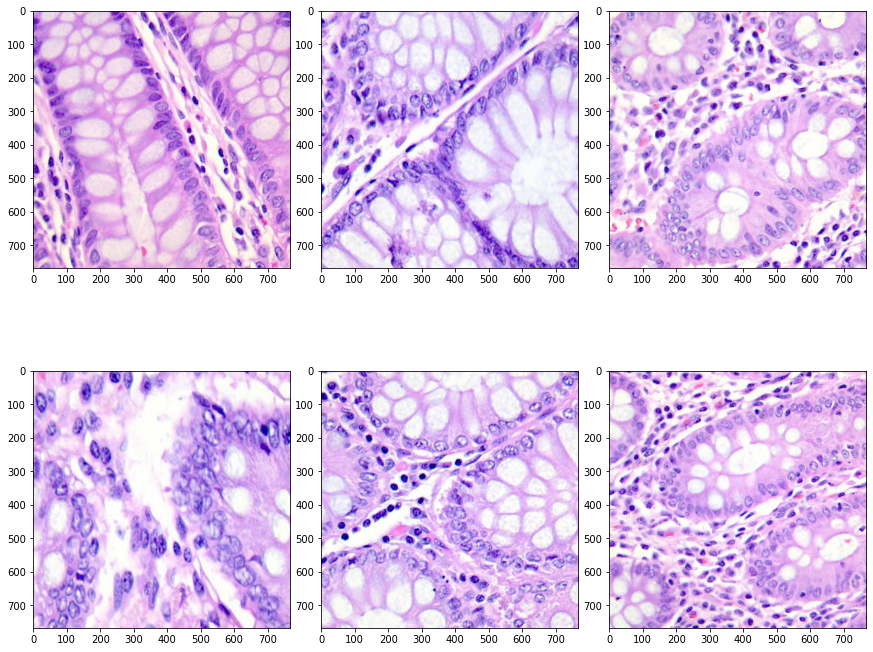

In [9]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5005]))
axs[0,1].imshow(show_image(*train[5010]))
axs[1, 0].imshow(show_image(*train[6000]))
axs[1,1].imshow(show_image(*train[6001]))
axs[0,2].imshow(show_image(*train[7000]))
axs[1,2].imshow(show_image(*train[7020]))

# Modeling

In [10]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.25
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split
            = 0.25)
train_data = train_gen.flow_from_directory(
                data_dir, 
                subset='training', 
                target_size=(224,224),
                batch_size=64,
                color_mode='rgb',
                class_mode='categorical',
                shuffle=True)

val_data = valid_gen.flow_from_directory(
                data_dir, 
                subset='validation', 
                target_size=(224,224),
                batch_size=64, 
                color_mode='rgb',
                class_mode='categorical', 
                shuffle=False)

Found 7500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 1250, 1: 1250}

## Model_1


In [12]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(128, activation='relu'))
model_1.add(keras.layers.Dense(2, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

2023-01-08 12:22:53.845180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0

In [13]:
history = model_1.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-08 12:22:56.205573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
118/118 [==============================] - 455s 4s/step - loss: 1.4860 - accuracy: 0.5645 - val_loss: 0.6679 - val_accuracy: 0.6320
Epoch 2/10
118/118 [==============================] - 409s 3s/step - loss: 0.6733 - accuracy: 0.5692 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/10
118/118 [==============================] - 406s 3s/step - loss: 0.6867 - accuracy: 0.5395 - val_loss: 0.6374 - val_accuracy: 0.6828
Epoch 4/10
118/118 [==============================] - 398s 3s/step - loss: 0.6592 - accuracy: 0.6101 - val_loss: 0.6795 - val_accuracy: 0.5228
Epoch 5/10
118/118 [==============================] - 397s 3s/step - loss: 0.6589 - accuracy: 0.6003 - val_loss: 0.6402 - val_accuracy: 0.5964
Epoch 6/10
118/118 [==============================] - 408s 3s/step - loss: 0.5260 - accuracy: 0.7543 - val_loss: 0.4495 - val_accuracy: 0.8060
Epoch 7/10
118/118 [==============================] - 411s 3s/step - loss: 0.4602 - accuracy: 0.7920 - val_loss: 0.4029 - val_accuracy: 0.8388

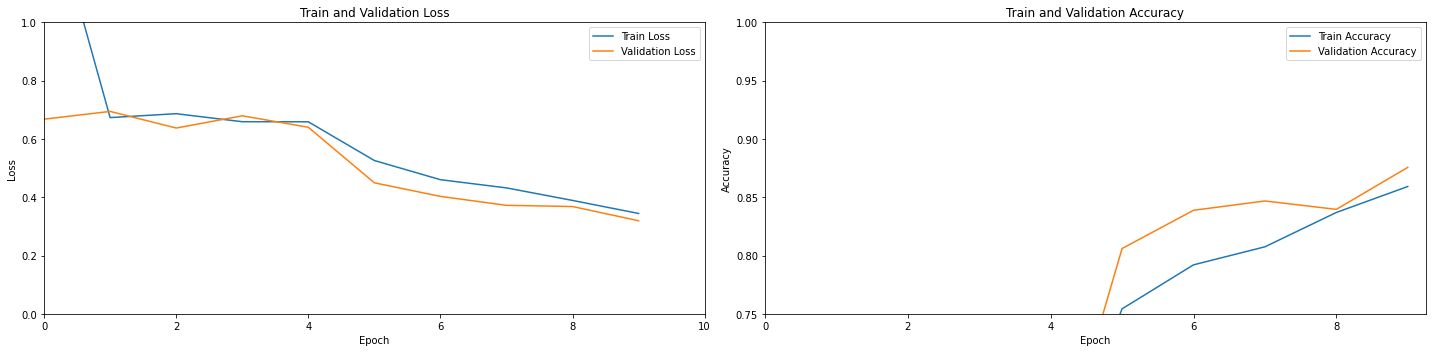

In [14]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [15]:
from sklearn.metrics import classification_report

Y_pred = model_1.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1250
           1       0.90      0.85      0.87      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



## Model_2

In [16]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(2, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               23888000  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [17]:
history = model_2.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
118/118 [==============================] - 344s 3s/step - loss: 1.2569 - accuracy: 0.6009 - val_loss: 0.7660 - val_accuracy: 0.5068
Epoch 2/10
118/118 [==============================] - 344s 3s/step - loss: 0.6280 - accuracy: 0.5979 - val_loss: 0.6906 - val_accuracy: 0.5592
Epoch 3/10
118/118 [==============================] - 339s 3s/step - loss: 0.5294 - accuracy: 0.7620 - val_loss: 0.5037 - val_accuracy: 0.7520
Epoch 4/10
118/118 [==============================] - 342s 3s/step - loss: 0.4660 - accuracy: 0.8088 - val_loss: 0.4920 - val_accuracy: 0.7996
Epoch 5/10
118/118 [==============================] - 342s 3s/step - loss: 0.4446 - accuracy: 0.8168 - val_loss: 0.5642 - val_accuracy: 0.7300
Epoch 6/10
118/118 [==============================] - 338s 3s/step - loss: 0.3828 - accuracy: 0.8508 - val_loss: 0.4608 - val_accuracy: 0.7916
Epoch 7/10
118/118 [==============================] - 359s 3s/step - loss: 0.3436 - accuracy: 0.8631 - val_loss: 0.4211 - val_accuracy: 0.8136

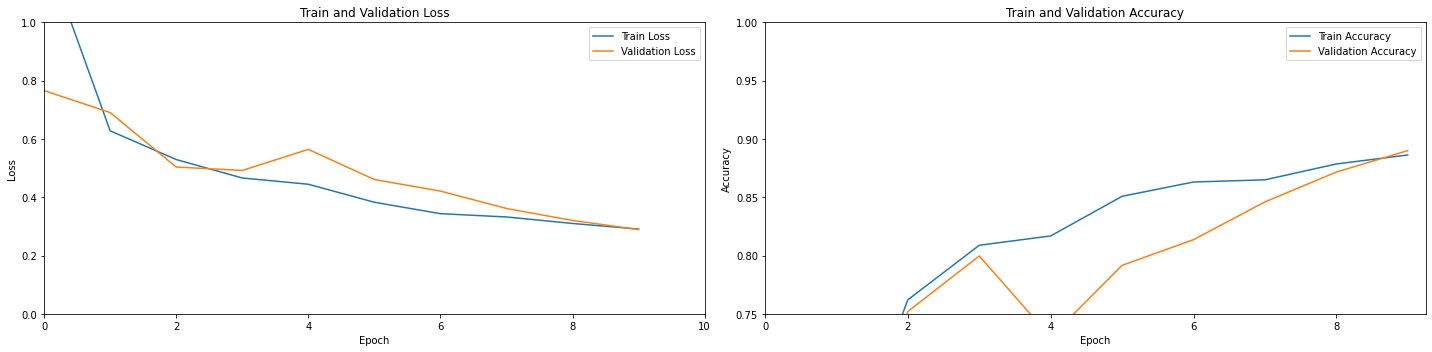

In [18]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [19]:
Y_pred = model_2.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1250
           1       0.86      0.93      0.89      1250

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



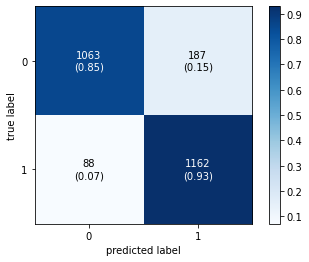

In [20]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()